In [1]:
from config import config

import pickle

import pandas as pd

In [2]:
with open(config["data"]["path"], "rb") as file:
    df = pickle.load(file)
    
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
target_column = "gender";
df.gender.value_counts()

Male          1270
Female         456
Non-Binary      25
Name: gender, dtype: int64

In [4]:
df = df[df["gender"].notna()]
# df = df[df["completed"] > config["min_completed"]]

In [5]:
predict_columns = ["completed", "days_watched", "episodes_watched", "mean_score"]
target_column = "gender"
df = df[predict_columns + [target_column]]

In [6]:
df.head()

,completed,days_watched,episodes_watched,mean_score,gender
1,1125,263.3,16195,7.80,Male
2,887,270.4,16189,7.36,Male
5,594,201.2,12248,5.42,Male
6,433,51.8,3252,5.36,Female
7,227,44.7,2799,7.96,Female


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 1 to 2193
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   completed         1751 non-null   int64   
 1   days_watched      1751 non-null   float64 
 2   episodes_watched  1751 non-null   int64   
 3   mean_score        1751 non-null   float64 
 4   gender            1751 non-null   category
dtypes: category(1), float64(2), int64(2)
memory usage: 70.2 KB


In [8]:
import umap
import numpy as np

@np.vectorize
def map_to_int(x):
    if x == "Male":
        return 0
    elif x == "Female":
        return 1
    else:
        return 2

X = df[predict_columns].values
y = map_to_int(df[[target_column]].values.flatten())

In [9]:
X

array([[1.12500e+03, 2.63300e+02, 1.61950e+04, 7.80000e+00],
       [8.87000e+02, 2.70400e+02, 1.61890e+04, 7.36000e+00],
       [5.94000e+02, 2.01200e+02, 1.22480e+04, 5.42000e+00],
       ...,
       [9.40000e+01, 3.94000e+01, 2.34300e+03, 8.19000e+00],
       [1.40250e+04, 1.92840e+03, 1.51474e+05, 5.92000e+00],
       [2.53000e+02, 6.57000e+01, 4.54200e+03, 7.24000e+00]])

In [10]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [11]:
reducer = umap.UMAP(n_neighbors=6, min_dist = 0.25, random_state=config["random_state"])
reducer.fit(X)

UMAP(min_dist=0.25, n_neighbors=6, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [12]:
X_reduced = reducer.transform(X)
X_reduced.shape

(1751, 2)

In [13]:
X_reduced

array([[ 19.621313 ,  11.951625 ],
       [ 19.580858 ,  11.795673 ],
       [ 13.318033 ,   9.657398 ],
       ...,
       [  2.3100934,   6.5728154],
       [-10.671941 ,   4.5366225],
       [  7.500849 ,  -5.0478683]], dtype=float32)

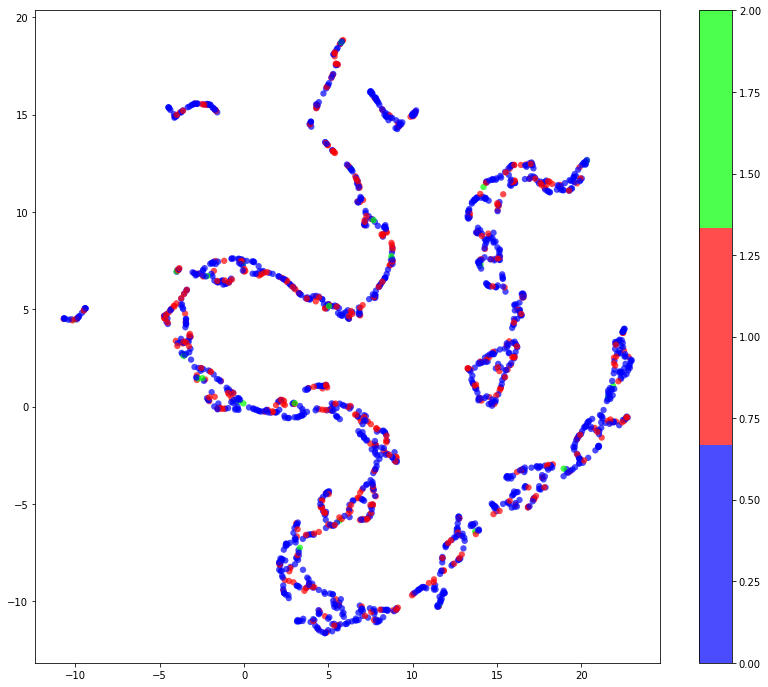

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('brg', 3))
plt.colorbar()
plt.show()

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=config["random_state"])
y_clusters = kmeans.fit_predict(X_reduced)

[0 1 2 3 4]


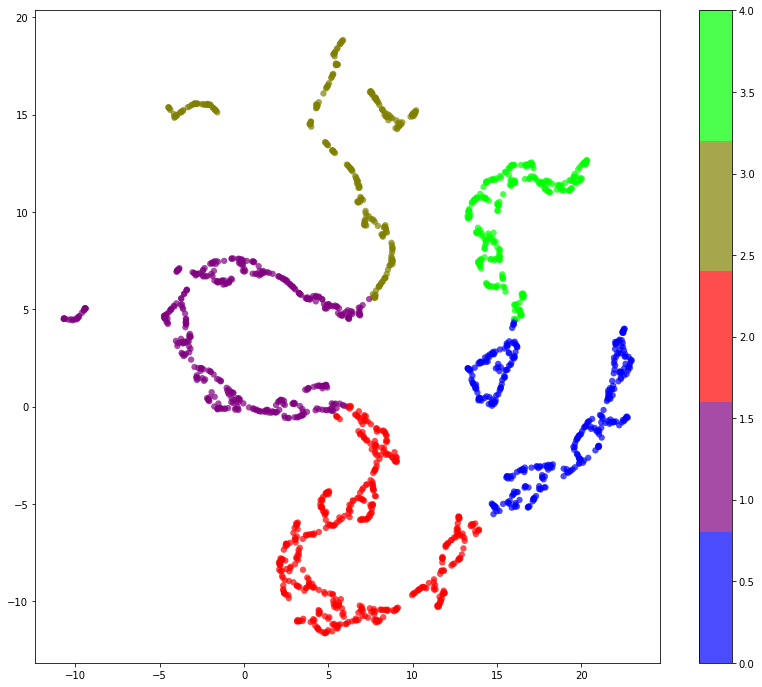

In [30]:
print(np.unique(y_clusters))
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_clusters, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('brg', 5))
plt.colorbar()
plt.show()

In [32]:
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances

def inner_dist(X, cluster, clusters):
    our_cluster = X[np.where(clusters == cluster)]
    other_clusters = X[np.where(clusters != cluster)]
    return euclidean_distances(our_cluster, our_cluster).sum() / ((our_cluster.shape[0]) * (our_cluster.shape[0] - 1))

def outer_dist(X, cluster, clusters):
    our_cluster = X[np.where(clusters == cluster)]
    other_clusters = X[np.where(clusters != cluster)]
    return euclidean_distances(our_cluster, other_clusters).mean()


def show_distances(X, clusters):
    sorted_clusters = sorted(set(clusters))
    clusters_counter = Counter(clusters)
    inner_dists = []
    outer_dists = []
    for cluster in sorted_clusters:
        if clusters_counter[cluster] == 1:
            print(f'cluster={cluster} -- выброс')
        else:
            inner = inner_dist(X, cluster, clusters)
            outer = outer_dist(X, cluster, clusters)
            inner_dists.append(inner)
            outer_dists.append(outer)
            print(f'cluster={cluster} inner_dist=[{inner}] outer_dist=[{outer}]')
    inner_dists = np.array(inner_dists)
    outer_dists = np.array(outer_dists)
    print(f'inner_dist_mean=[{inner_dists.mean()}] outer_dist_mean=[{outer_dists.mean()}]') 


In [33]:
from math import sqrt
from collections import namedtuple

Distances = namedtuple("Distances", "inner outer")

def ro(x1, x2):
    return sqrt(sum((x1 - x2) ** 2))

def distances(X, y):
    assert(len(X) == len(y))
    inner_ro_sum = 0.0
    outer_ro_sum = 0.0
    eq_sum = 0
    neq_sum = 0
    for i in range(len(X)):
        if y[i] == -1:
            continue
        for j in range(i):
            if y[j] == -1:
                continue
            ro_ = ro(X[i], X[j])
            if y[i] == y[j]:
                eq_sum += 1
                inner_ro_sum += ro_
            else:
                neq_sum += 1
                outer_ro_sum += ro_
    return Distances(inner_ro_sum / eq_sum, outer_ro_sum / neq_sum)

In [34]:
dist = distances(X_reduced, y_clusters)
dist

Distances(inner=5.683358661270299, outer=15.996334178962702)

In [35]:
dist[0] / dist[1]

0.35529131847874673

In [44]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2, min_samples=7)
y_clusters = dbscan.fit_predict(X_reduced)

[0 1 2 3 4]


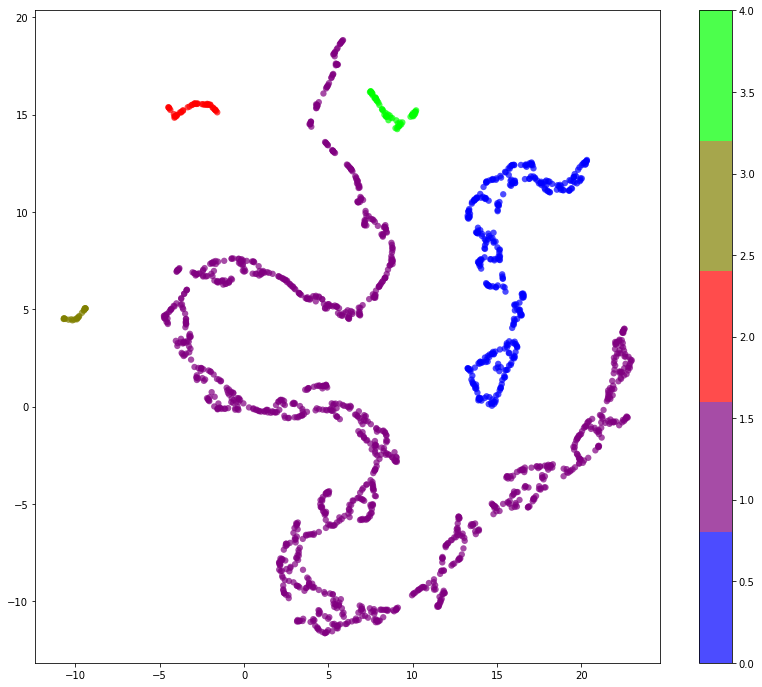

In [45]:
print(np.unique(y_clusters))
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_clusters, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('brg', 5))
plt.colorbar()
plt.show()

In [46]:
dist = distances(X_reduced, y_clusters)
dist

Distances(inner=12.157867293206083, outer=15.994424792913398)

In [47]:
dist[0] / dist[1]

0.7601315740090155